# CellMap for hippocampus cell data

The tutorial for hippocampus cell data ([La Manno et al. (2018)](https://doi.org/10.1038/s41586-018-0414-6)).


[RECODE](https://github.com/yusuke-imoto-lab/RECODE) is used for the noise reduction.

## Regular procedure

In [2]:
import cellmap
import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy

The dataset is installed using the [scvelo](https://scvelo.readthedocs.io/en/stable/) package. 

In [3]:
import scvelo as scv
adata = scv.datasets.dentategyrus_lamanno()
adata

AnnData object with n_obs × n_vars = 18213 × 27998
    obs: 'Age', 'clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'clusters_colors'
    obsm: 'X_tsne'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

Noise reduction by [RECODE](https://github.com/yusuke-imoto-lab/RECODE).

/home/yusukeimoto/.local/lib/python3.10/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/yusukeimoto/.local/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


start RECODE for scRNA-seq
end RECODE for scRNA-seq
log: {'seq_target': 'RNA', '#significant genes': 12242, '#non-significant genes': 7644, '#silent genes': 8112, 'ell': 137, 'Elapsed time': '0h 3m 3s 794ms'}


/home/yusukeimoto/.local/lib/python3.10/site-packages/screcode/screcode.py:708: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  dens = scipy.stats.kde.gaussian_kde(np.log10(norm_var[norm_var>0]))(x)


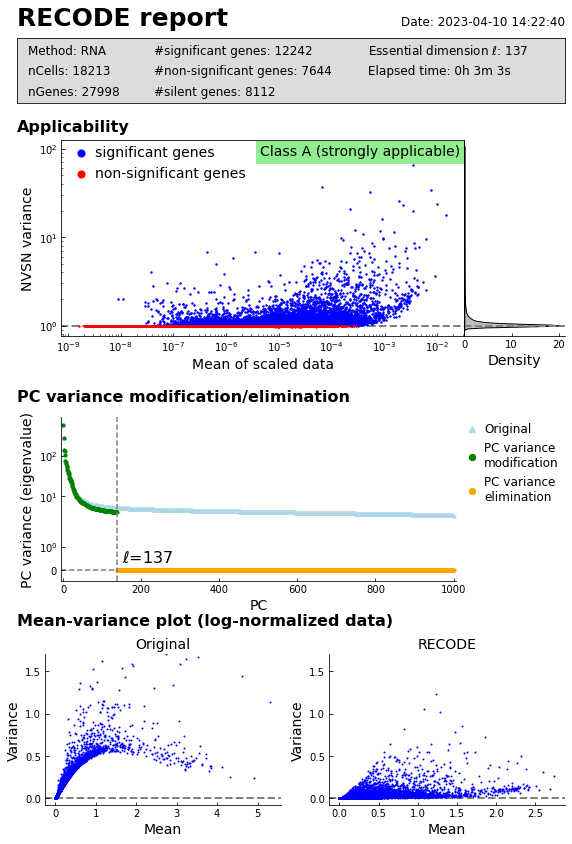

In [4]:
import screcode
recode = screcode.RECODE()
adata.layers['RECODE'] = recode.fit_transform(adata.X.toarray())
adata.layers['RECODE_log'] = scanpy.pp.log1p(adata.layers['RECODE'])
recode.report()

In [5]:
adata.layers['spliced'] = recode.transform(adata.layers['spliced'])
adata.layers['unspliced'] = recode.transform(adata.layers['unspliced'])

RECODE does not support sparse input. The input and output are transformed as regular matricies. 
RECODE does not support sparse input. The input and output are transformed as regular matricies. 


In [6]:
scanpy.pp.normalize_total(adata, target_sum=1e4,layer='RECODE')
scanpy.pp.log1p(adata,layer='RECODE')

Compute velocity by scVelo (stochastic mode) and show the stream on UMAP. 

In [7]:
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata)
scv.tl.velocity(adata,mode='stochastic')
scv.tl.velocity_graph(adata)

Normalized count data: X.
computing neighbors


2023-04-10 14:25:11.459678: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-10 14:25:12.123139: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 14:25:15.295186: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 14:25:15.312595: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 14:25:24.828471: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

    finished (0:01:34) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:03:53) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:04:27) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/18213 [00:00<?, ?cells/s]

    finished (0:26:41) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:07) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


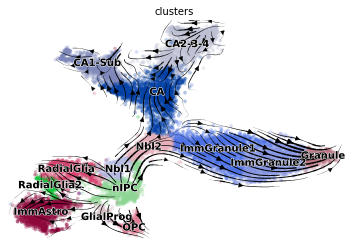

In [8]:
scv.pl.velocity_embedding_stream(adata)

In [9]:
%%time
import cellmap

cellmap.Hodge_decomposition(adata, exp_2d_key='X_tsne', vel_2d_key='velocity_tsne', alpha=0.1)

{'Contribution_ratio': {'Potential': '55.92%', 'Rotation': '44.08%'}}
CPU times: user 3h 43min 31s, sys: 1h 6min 22s, total: 4h 49min 54s
Wall time: 47min 26s


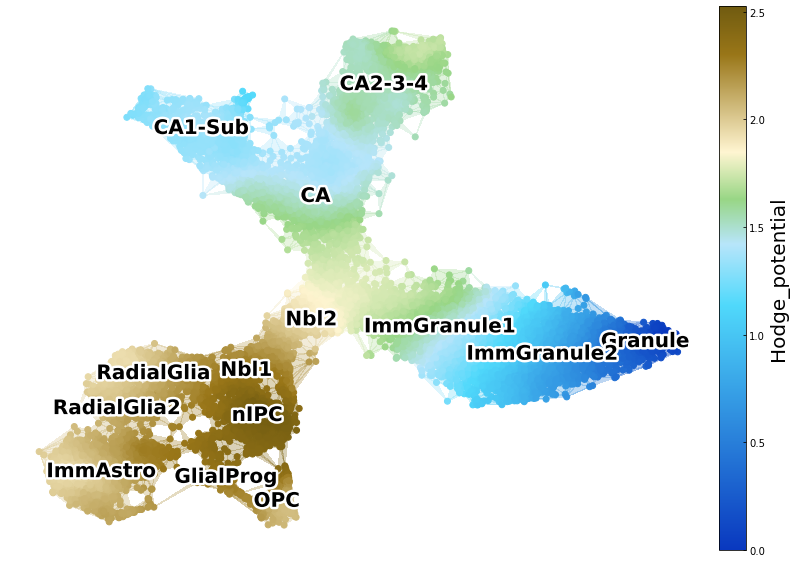

In [10]:
cellmap.view(adata, basis='X_tsne', show_graph = True, cluster_key='clusters')

In [11]:
def view_stream(
    adata,
    basis = 'X_umap',
    vel_2d_key = 'velocity_umap',
    potential_key = 'Hodge_potential',
    rotation_key = 'Hodge_rotation',
    graph_key = 'CM_graph',
    cluster_key = None,
    show_graph = False,
    cutedge_vol  = None,
    cutedge_length = None,
    title = '',
    density = 5,
    **kwargs
    ):
    
    kwargs_arg = check_arguments(adata,
                             basis = basis,
                             potential_key = potential_key,
                             graph_key = graph_key,
                            )
    basis = kwargs_arg['basis']
    
    if 'cmap' not in kwargs:
        kwargs['cmap'] = cmap_earth(adata.obs[potential_key])
    
    data_pos = adata.obsm[basis]
    tri_,idx_tri = create_graph(data_pos[:,0],data_pos[:,1],cutedge_vol=cutedge_vol,cutedge_length=cutedge_length,return_mask = True)
    source, target = np.ravel(tri_.triangles[idx_tri][:,[0,1,2]]),np.ravel(tri_.triangles[idx_tri][:,[1,2,0]])
    vel_potential = np.zeros([adata.shape[0],2],dtype=float)
    vel_ratation  = np.zeros([adata.shape[0],2],dtype=float)
    for i in range(len(source)):
        ex = (data_pos[target[i]]-data_pos[source[i]])/np.linalg.norm(data_pos[target[i]]-data_pos[source[i]])
        vel_potential[source[i]] +=  (adata.obs[potential_key][source[i]]-adata.obs[potential_key][target[i]])*ex
        vel_potential[target[i]] += -(adata.obs[potential_key][target[i]]-adata.obs[potential_key][source[i]])*ex
        vel_ratation[source[i]]  +=  (adata.obs[rotation_key][source[i]]-adata.obs[rotation_key][target[i]])*ex
        vel_ratation[target[i]]  += -(adata.obs[rotation_key][target[i]]-adata.obs[rotation_key][source[i]])*ex
    # print(target[source==0])
    # print(source[target==0])
    # print(adata.obsm[vel_2d_key])
    adata.obsm['polential_velocity_umap'] = vel_potential
    adata.obsm['rotation_velocity_umap']  = vel_ratation
    
    fig,ax = plt.subplots(1,2,figsize=(20,10),tight_layout=True)
    scv.pl.velocity_embedding_stream(adata,basis='umap',vkey='polential_velocity', title='Potential flow',ax=ax[0],
                                     show=False,density=density,alpha=0.5,fontsize=18,legend_fontsize=16, legend_loc=None,arrow_size=2,linewidth=2)
    scv.pl.velocity_embedding_stream(adata,basis='umap',vkey='rotation_velocity', title='Rotation flow',ax=ax[1],
                                     show=False,density=density,alpha=0.5,fontsize=18,legend_fontsize=16, legend_loc='right margin',arrow_size=2,linewidth=2)
    

view_stream(adata, basis='X_tsne', show_graph = True, cluster_key='clusters')

NameError: name 'check_arguments' is not defined

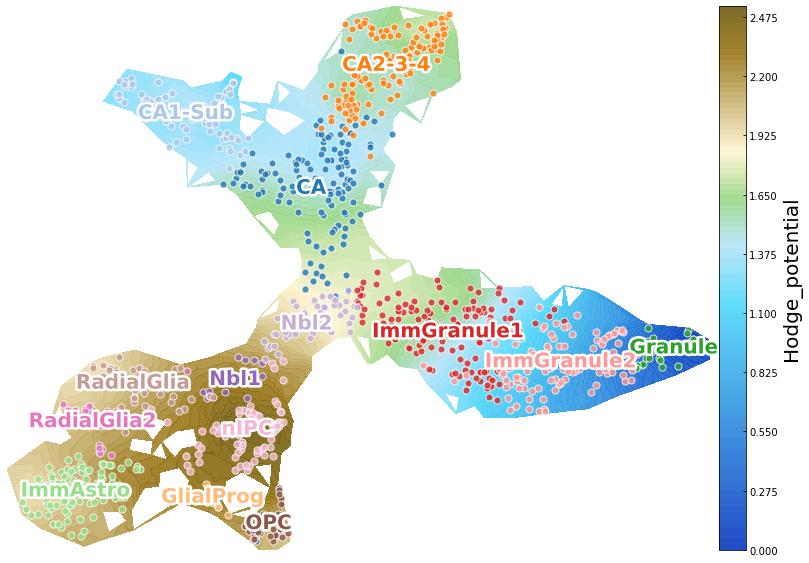

In [10]:
cellmap.view_cluster(adata, basis='X_tsne', show_graph=True, cluster_key='clusters', s=50)

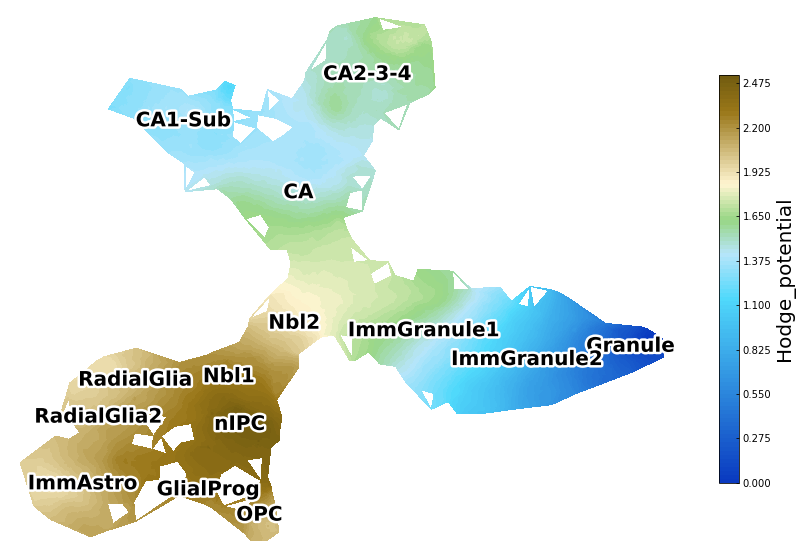

In [11]:
cellmap.view_surface(adata, basis='X_tsne', cluster_key ='clusters')

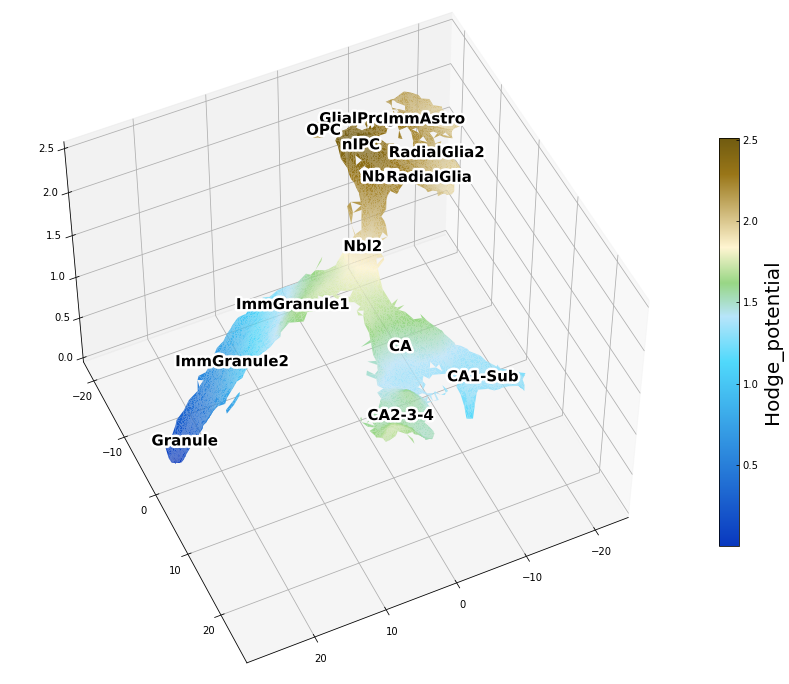

In [12]:
cellmap.view_surface_3D(adata, basis='X_tsne', cluster_key ='clusters', elev=50, azim=65)

500 18213 500


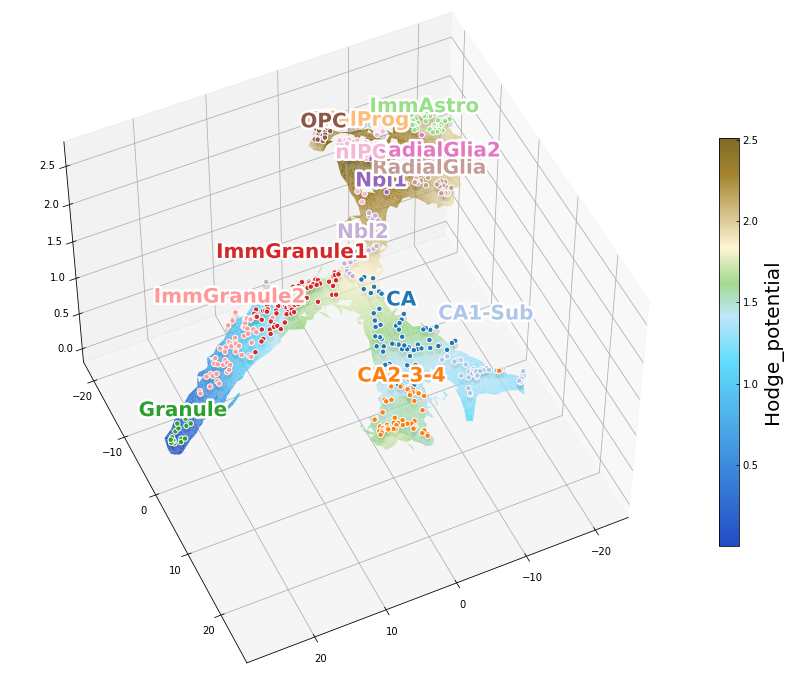

In [13]:
cellmap.view_surface_3D_cluster(adata, basis='X_tsne', cluster_key ='clusters',elev=50,azim=65,s=30);

### Write expression and potential data as CSV file for **[CellMap viewer](https://github.com/yusuke-imoto-lab/CellMapViewer)**. 

In [14]:
cellmap.write(adata, basis='X_tsne', filename='CellMap_tutorial_hippocampus',genes=['Aqp4','Aldoc','Cdk1','Mki67','Eomes','Neurod2'],expression_key='RECODE_log',use_HVG=False)

succeeded in writing CellMapp data as "CellMap_tutorial_hippocampus.csv"
You can visualize the CDV file by CellMapp viewer https://yusuke-imoto-lab.github.io/CellMapViewer/CellMapViewer/viewer.html


X          Y  Potential   Annotation  \
CellID                                                                    
10X83_2:AAACGGGGTCTCTTTAx  18.931086  -1.862429   0.717137  ImmGranule2   
10X83_2:AACCATGGTTCAACCAx  18.419891  -1.282895   0.783485  ImmGranule2   
10X83_2:AACACGTTCTGAAAGAx   2.369887  16.868419   1.560410      CA2-3-4   
10X83_2:AAAGATGCATTGAGCTx  -5.351040  10.676485   1.485099           CA   
10X83_2:AACCATGTCTACTTACx  -6.189126  11.754900   1.409671      CA1-Sub   
...                              ...        ...        ...          ...   
10X84_3:TTTCCTCCACCATCCTx  10.812611  -2.487668   1.346193  ImmGranule1   
10X84_3:TTTGTCACATGAAGTAx   8.246204  23.482788   1.713630      CA2-3-4   
10X84_3:TTTCCTCCACGGTAAGx  -3.441272  -4.917364   2.168985         nIPC   
10X84_3:TTTGTCAAGCGTCAAGx  16.394199  -6.143549   0.746790  ImmGranule2   
10X84_3:TTTCCTCGTGAAAGAGx  17.490857  -4.130190   0.744693  ImmGranule2   

                               Aqp4     Aldoc      Cdk1     Mki67     Eomes  \
CellID                                                                        
10X83_2:AAACGGGGTCTCTTTAx  0.000000  0.391166  0.000000  0.251287  0.328860   
10X83_2:AACCATGGTTCAACCAx  0.000000  0.000000  0.061143  0.000000  0.430350   
10X83_2:AACACGTTCTGAAAGAx  0.000000  0.966399  0.096205  0.213810  0.222181   
10X83_2:AAAGATGCATTGAGCTx  0.128158  0.000000  0.119707  0.000000  0.132120   
10X83_2:AACCATGTCTACTTACx  0.736064  1.217783  0.000000  0.024138  0.393682   
...                             ...       ...       ...       ...       ...   
10X84_3:TTTCCTCCACCATCCTx  0.085957  0.000000  0.002619  0.000000  0.000000   
10X84_3:TTTGTCACATGAAGTAx  0.000000  0.000000  0.000000  0.254708  0.000000   
10X84_3:TTTCCTCCACGGTAAGx  0.000000  0.000000  0.000000  0.466628  1.874376   
10X84_3:TTTGTCAAGCGTCAAGx  0.041858  0.000000  0.000000  0.146830  0.119205   
10X84_3:TTTCCTCGTGAAAGAGx  0.000000  1.423175  0.417029  0.000000  0.354386   

                            Neurod2  
CellID                               
10X83_2:AAACGGGGTCTCTTTAx  1.342433  
10X83_2:AACCATGGTTCAACCAx  1.598573  
10X83_2:AACACGTTCTGAAAGAx  1.433490  
10X83_2:AAAGATGCATTGAGCTx  2.217093  
10X83_2:AACCATGTCTACTTACx  2.155586  
...                             ...  
10X84_3:TTTCCTCCACCATCCTx  1.959970  
10X84_3:TTTGTCACATGAAGTAx  1.574311  
10X84_3:TTTCCTCCACGGTAAGx  0.000000  
10X84_3:TTTGTCAAGCGTCAAGx  1.826508  
10X84_3:TTTCCTCGTGAAAGAGx  1.862027  

[18213 rows x 10 columns]

## Changing parameter $\alpha$

The parameter $\alpha$ adjust the rate of original/reduced dimensional information of gene expression and velocity. 

$\alpha=0$ uses only two-dimensional inormation; in contrast, $\alpha=1$ uses the original (non-dimensionaly reduction) information. 

In [15]:
alpha_set = [0,0.5,1]
for alpha in alpha_set:
    cellmap.Hodge_decomposition(adata, exp_2d_key='X_tsne', vel_2d_key='velocity_tsne',potential_key='Hodge_potential_%0.1f' % alpha,alpha=alpha)
adata

{'Contribution_ratio': {'Potential': '54.69%', 'Rotation': '45.31%'}}
{'Contribution_ratio': {'Potential': '71.11%', 'Rotation': '28.89%'}}
{'Contribution_ratio': {'Potential': '75.27%', 'Rotation': '24.73%'}}


AnnData object with n_obs × n_vars = 18213 × 27998
    obs: 'Age', 'clusters', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'Hodge_potential', 'Hodge_rotation', 'Hodge_potential_0.0', 'Hodge_potential_0.5', 'Hodge_potential_1.0'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'log1p', 'pca', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'clusters_colors', 'CellMap_log', 'CM_graph'
    obsm: 'X_tsne', 'X_pca', 'velocity_tsne'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'RECODE', 'RECODE_log', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

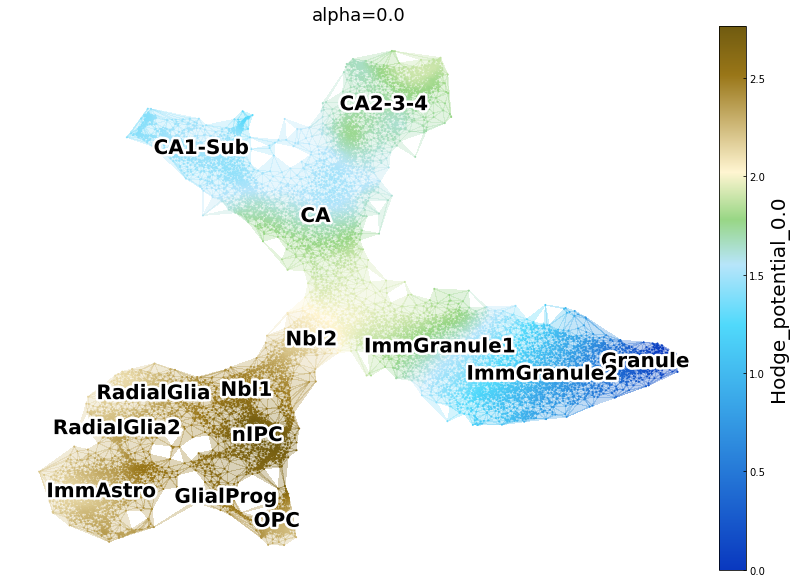

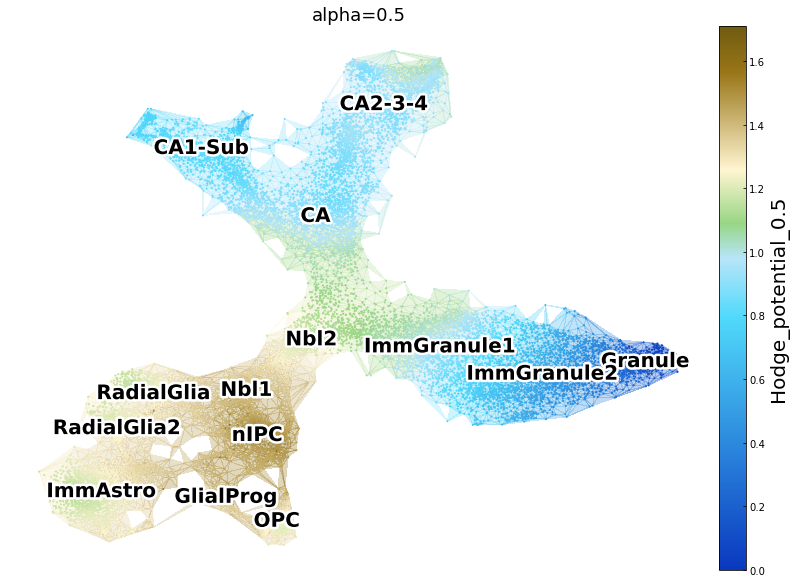

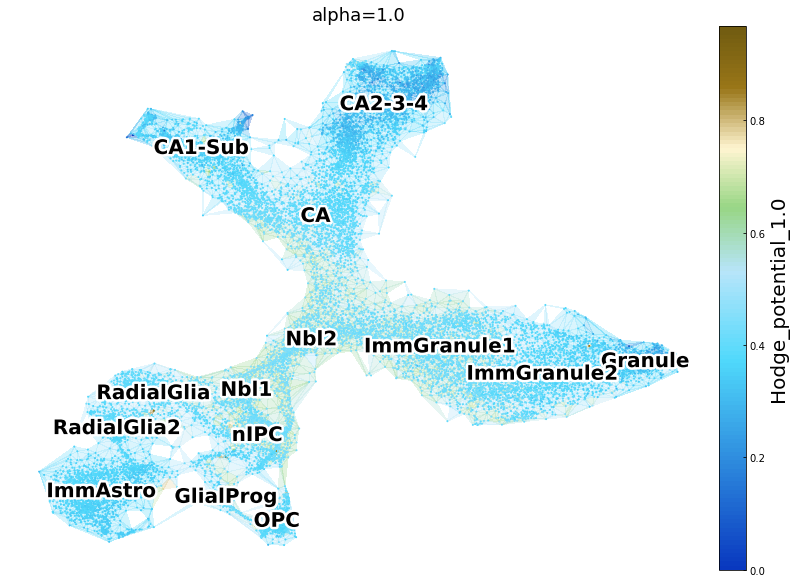

In [16]:
for alpha in alpha_set:
    cellmap.view(adata, basis='X_tsne', show_graph = True, potential_key='Hodge_potential_%0.1f' % alpha,cluster_key='clusters',title='alpha=%0.1f' % alpha,s=1)

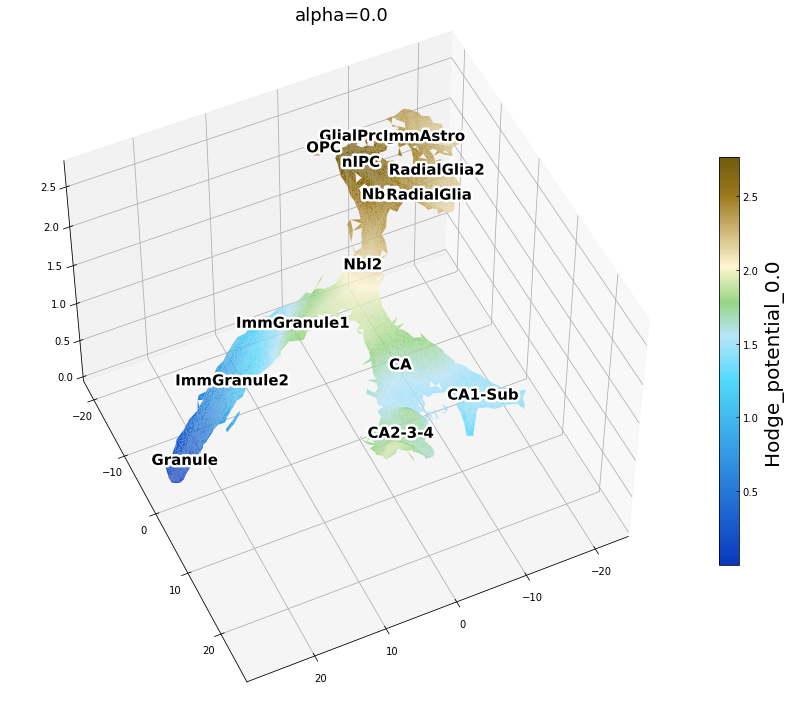

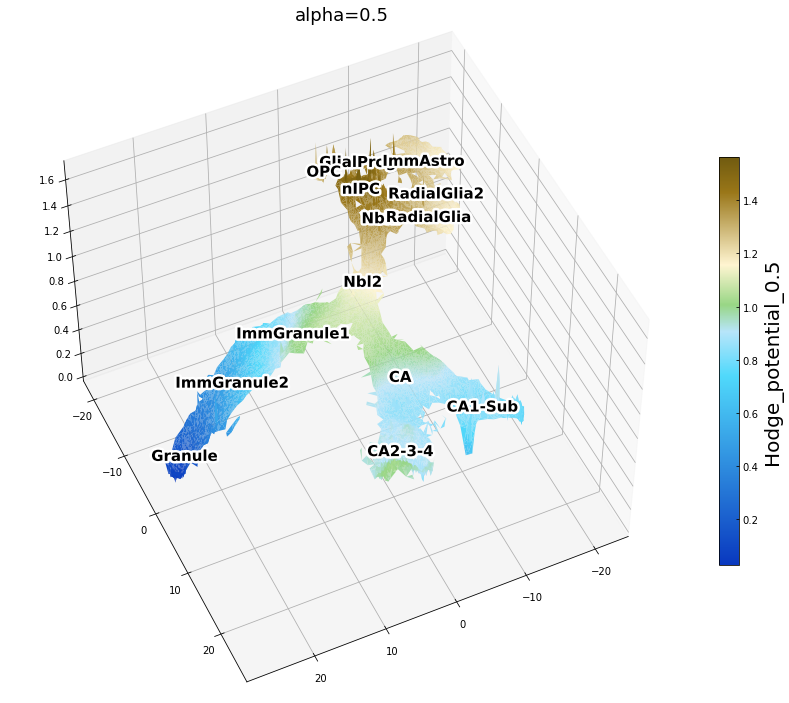

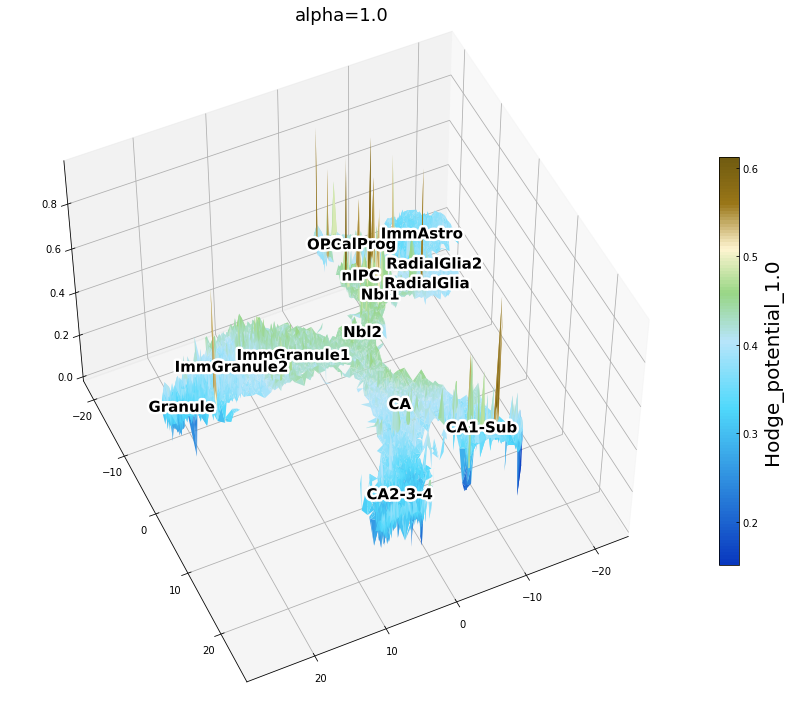

In [17]:
for alpha in alpha_set:
    cellmap.view_surface_3D(adata, basis='X_tsne', cluster_key ='clusters',potential_key='Hodge_potential_%0.1f' % alpha,elev=50,azim=65,title='alpha=%0.1f' % alpha)

In [21]:
n_genes = 10
genes = np.array(adata.var.index[np.argsort(np.var(adata.layers['RECODE_log'],axis=0))[::-1]][:n_genes])
adata.layers['velocity_log'] = (1e+4*adata.layers['velocity'].T/adata.obs['n_counts'].values).T/np.power(2,adata.layers['RECODE_log'])
genes = np.array(adata.var.index[np.argsort(np.var(adata.layers['velocity_log'],axis=0))[::-1]][:n_genes])
cellmap.Hodge_decomposition_genes(adata,genes,exp_key='RECODE_log')

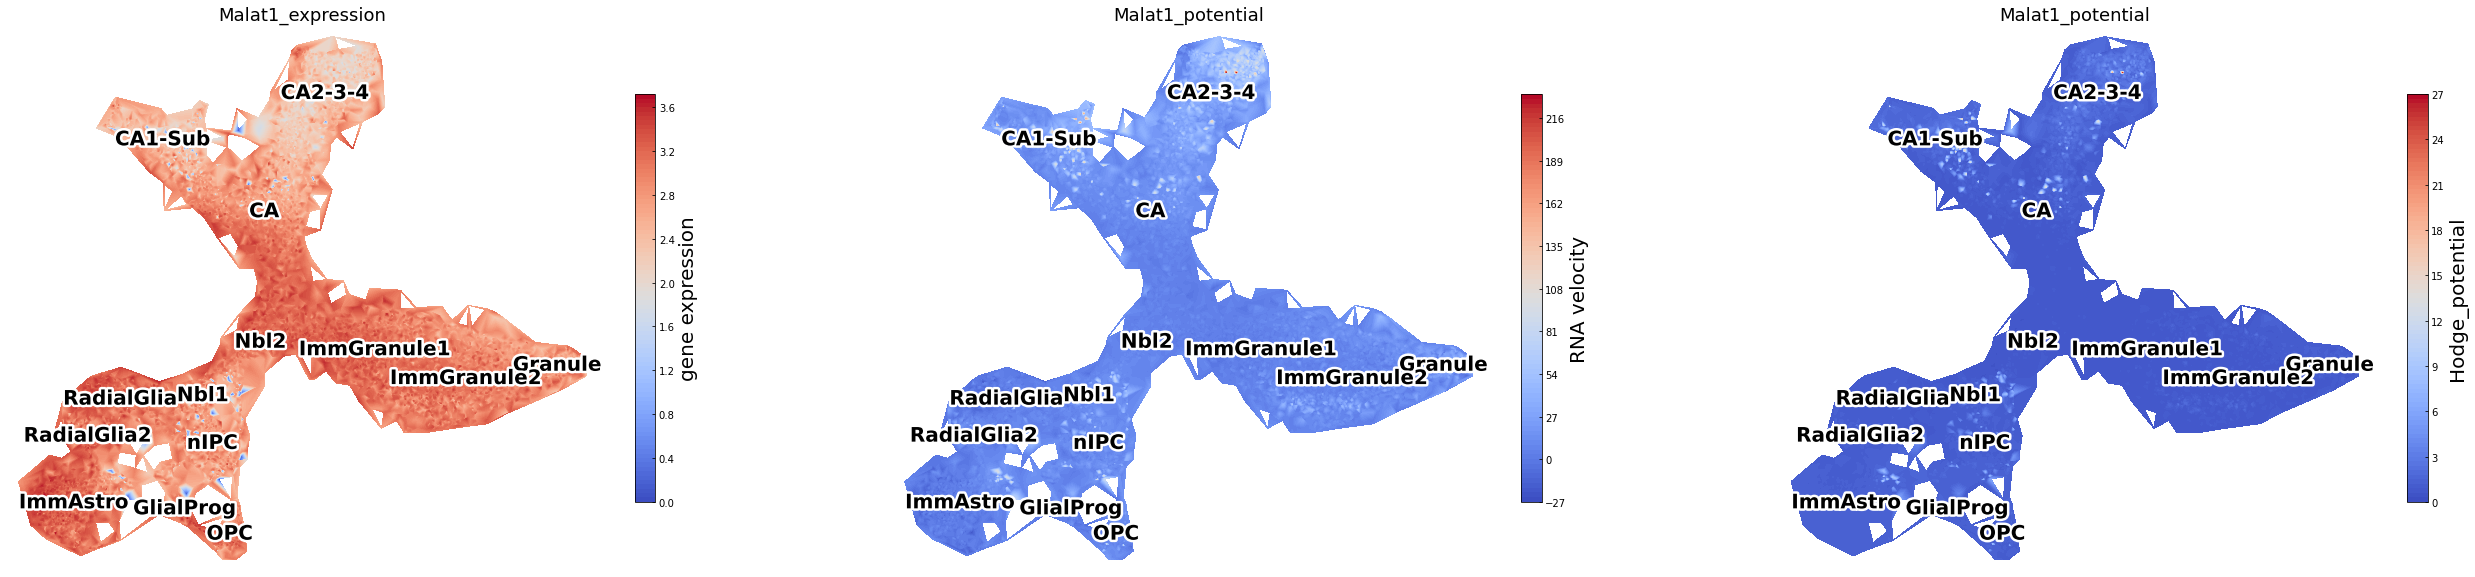

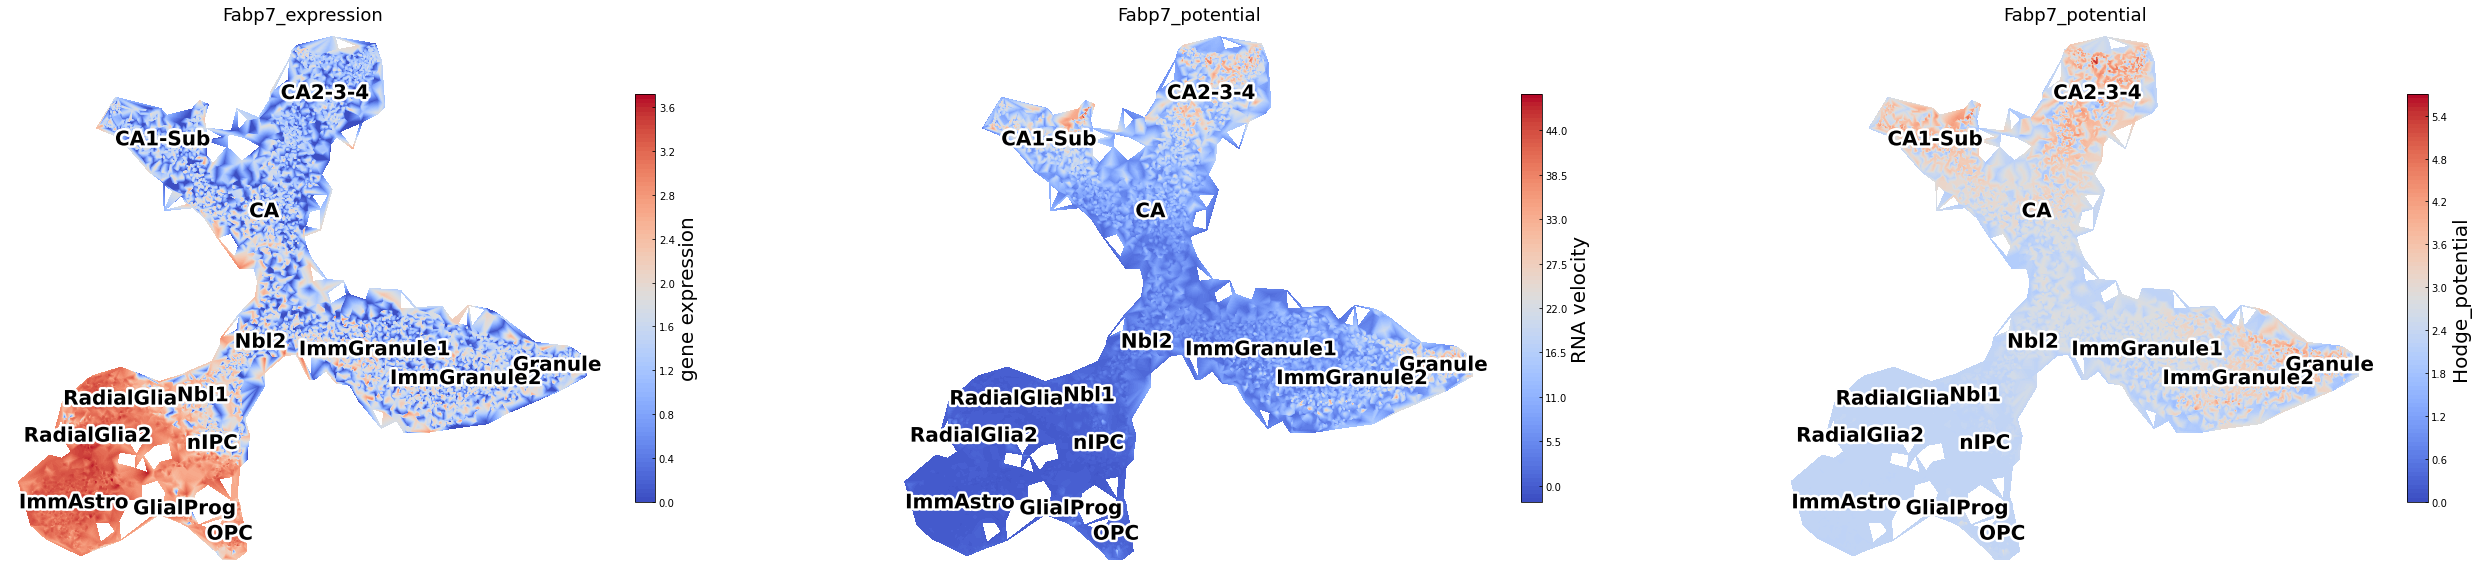

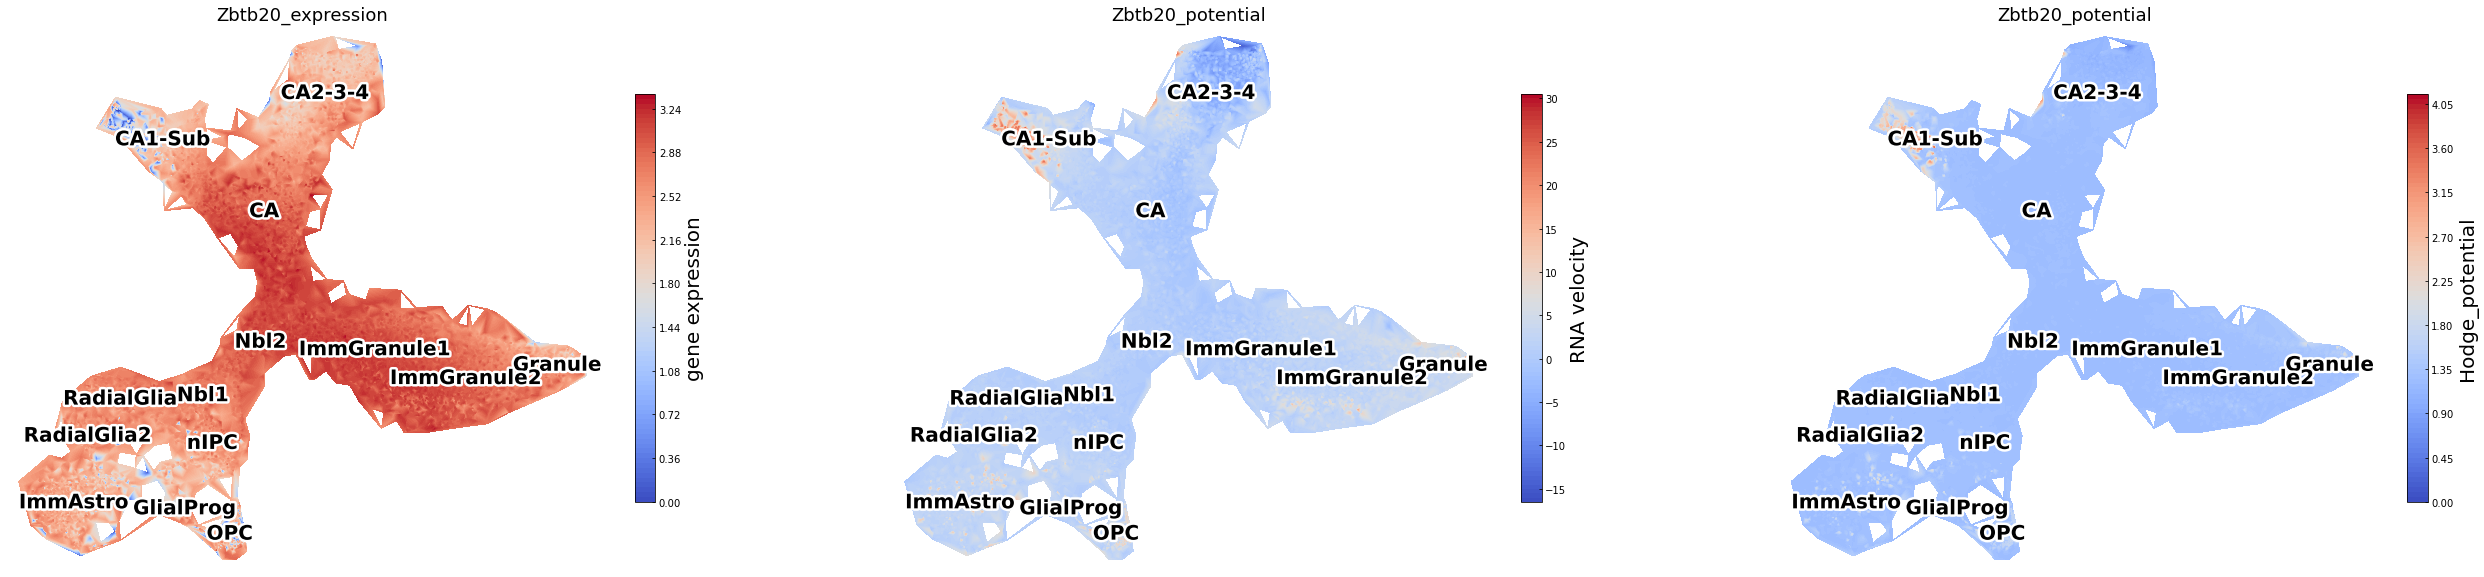

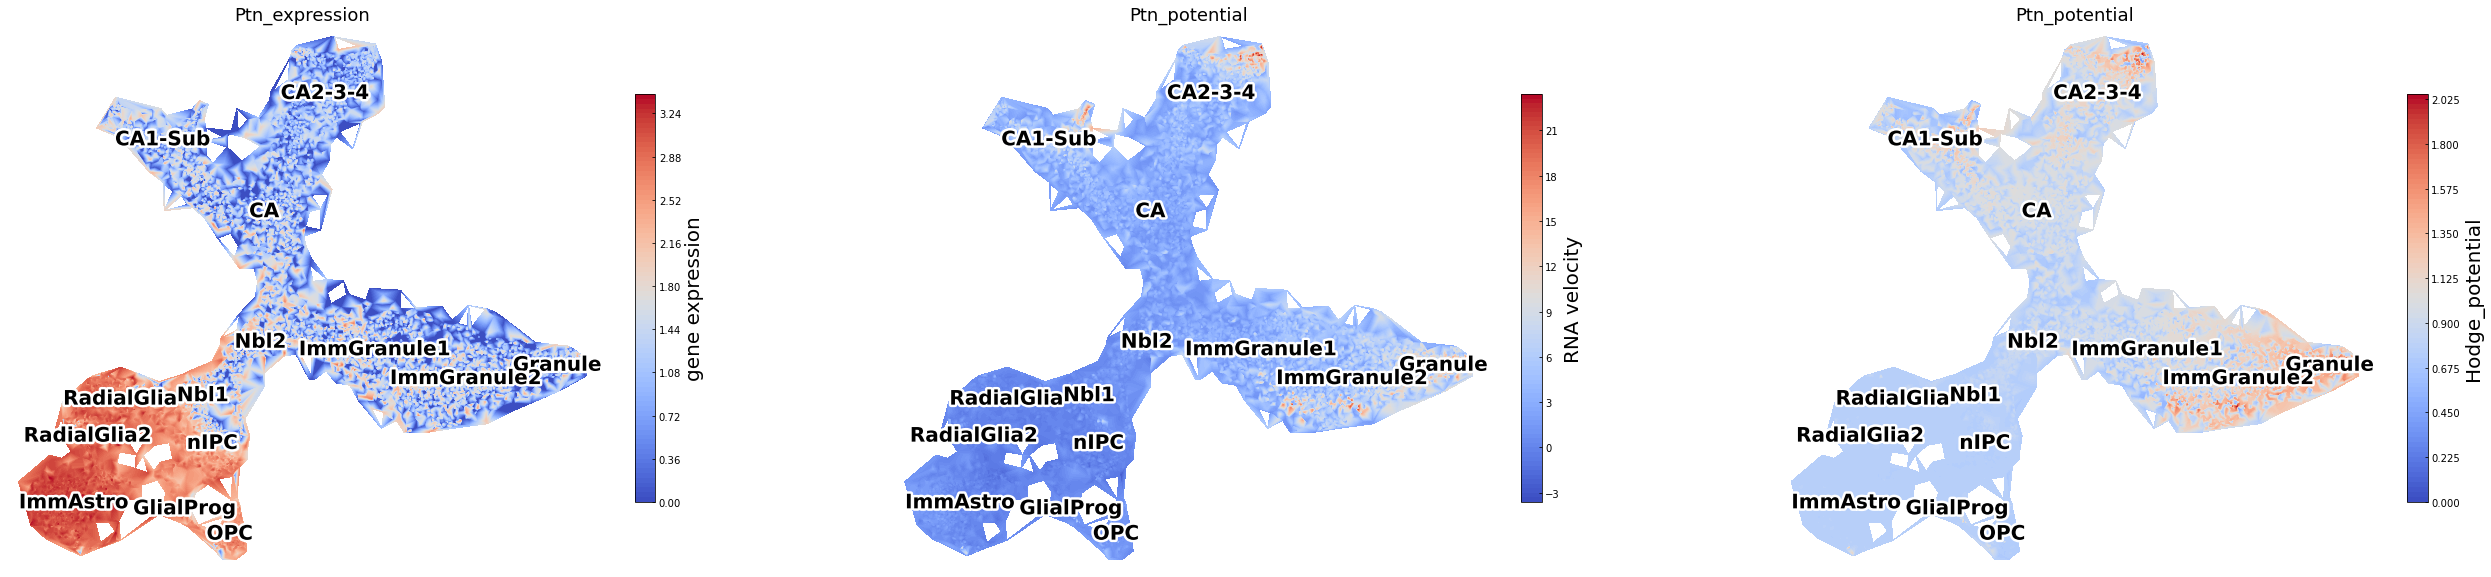

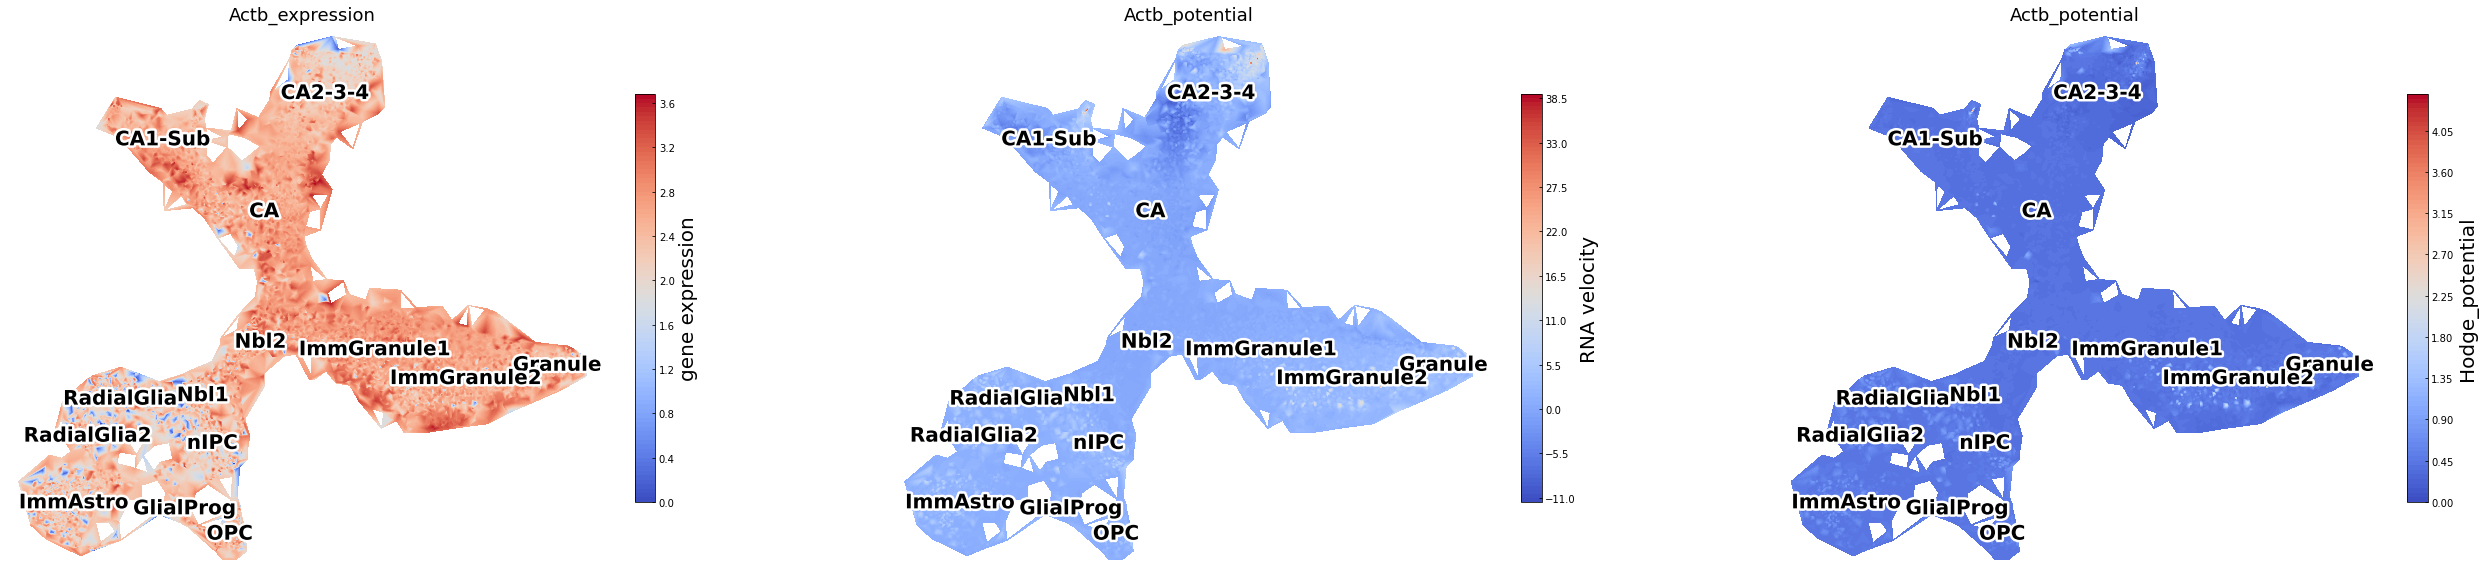

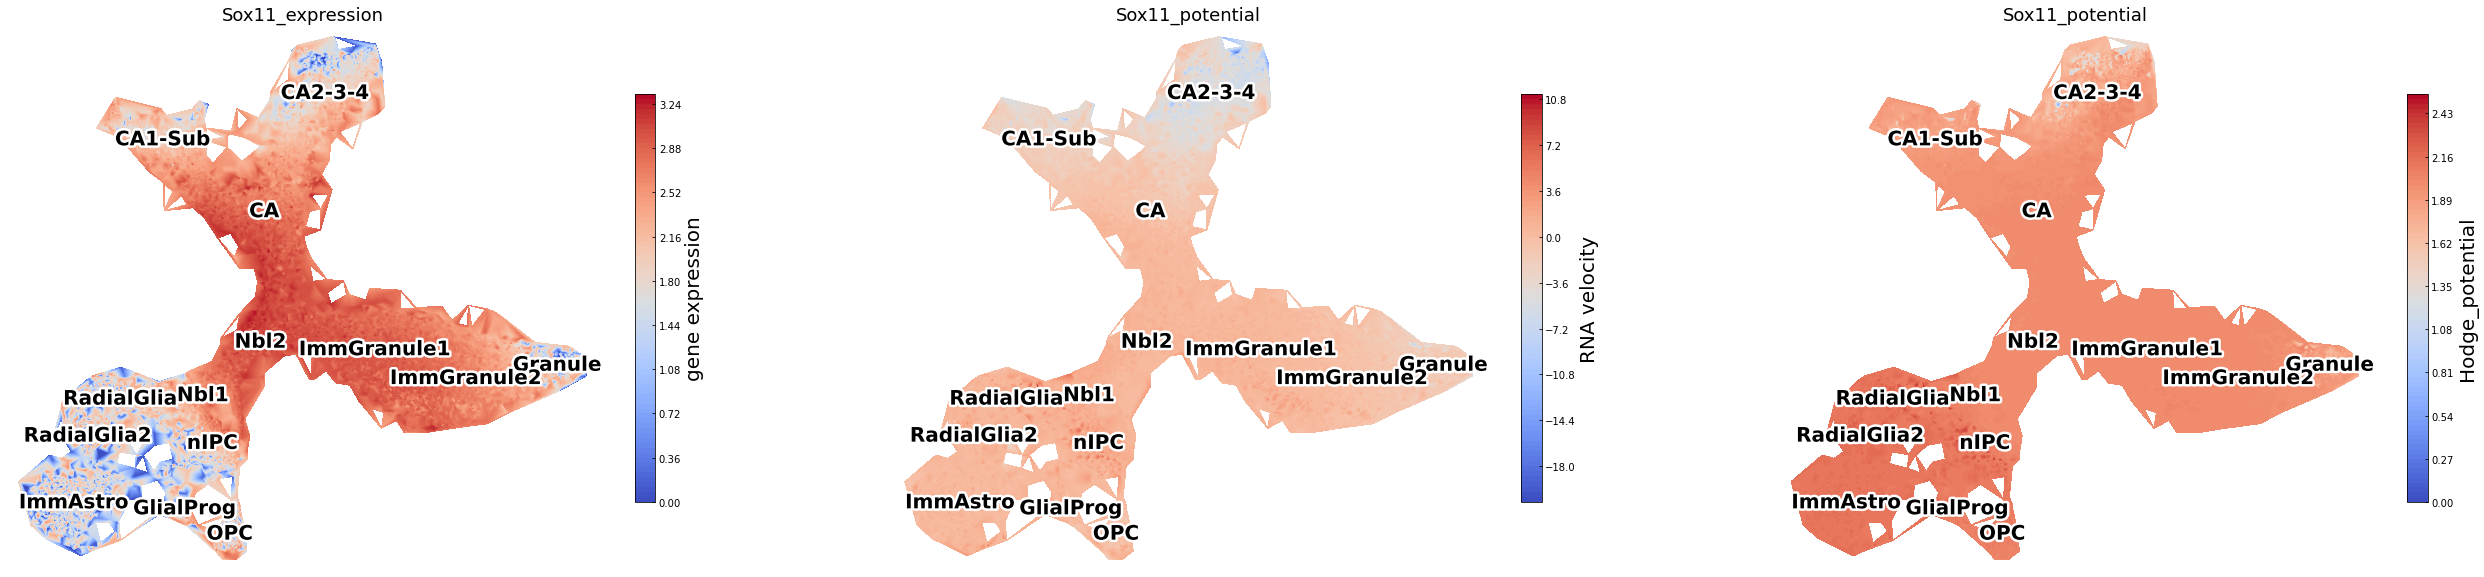

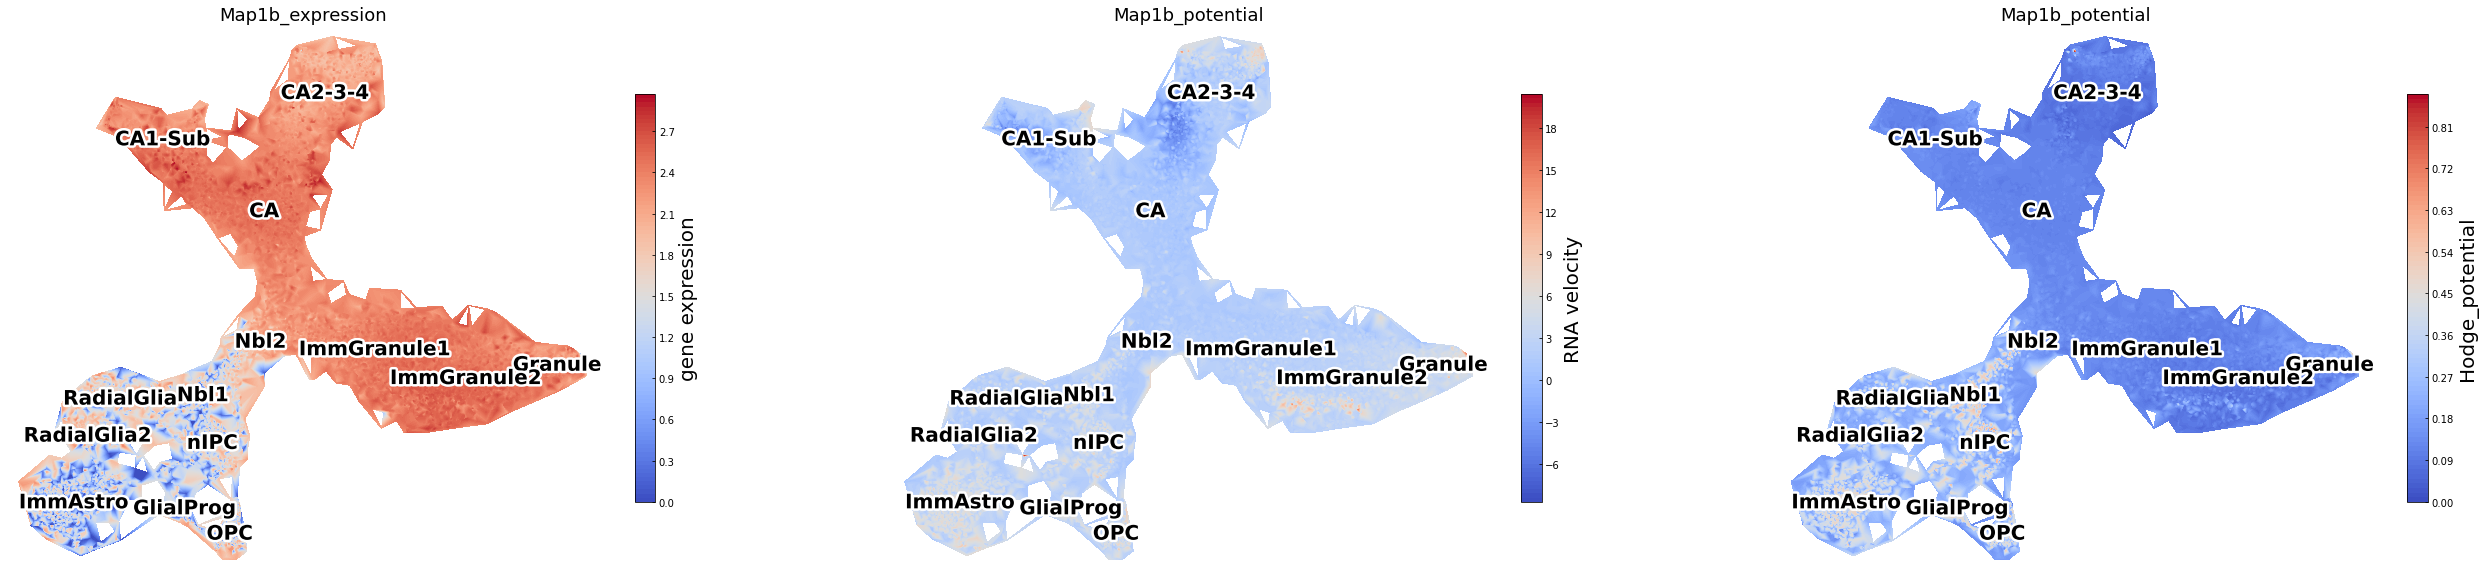

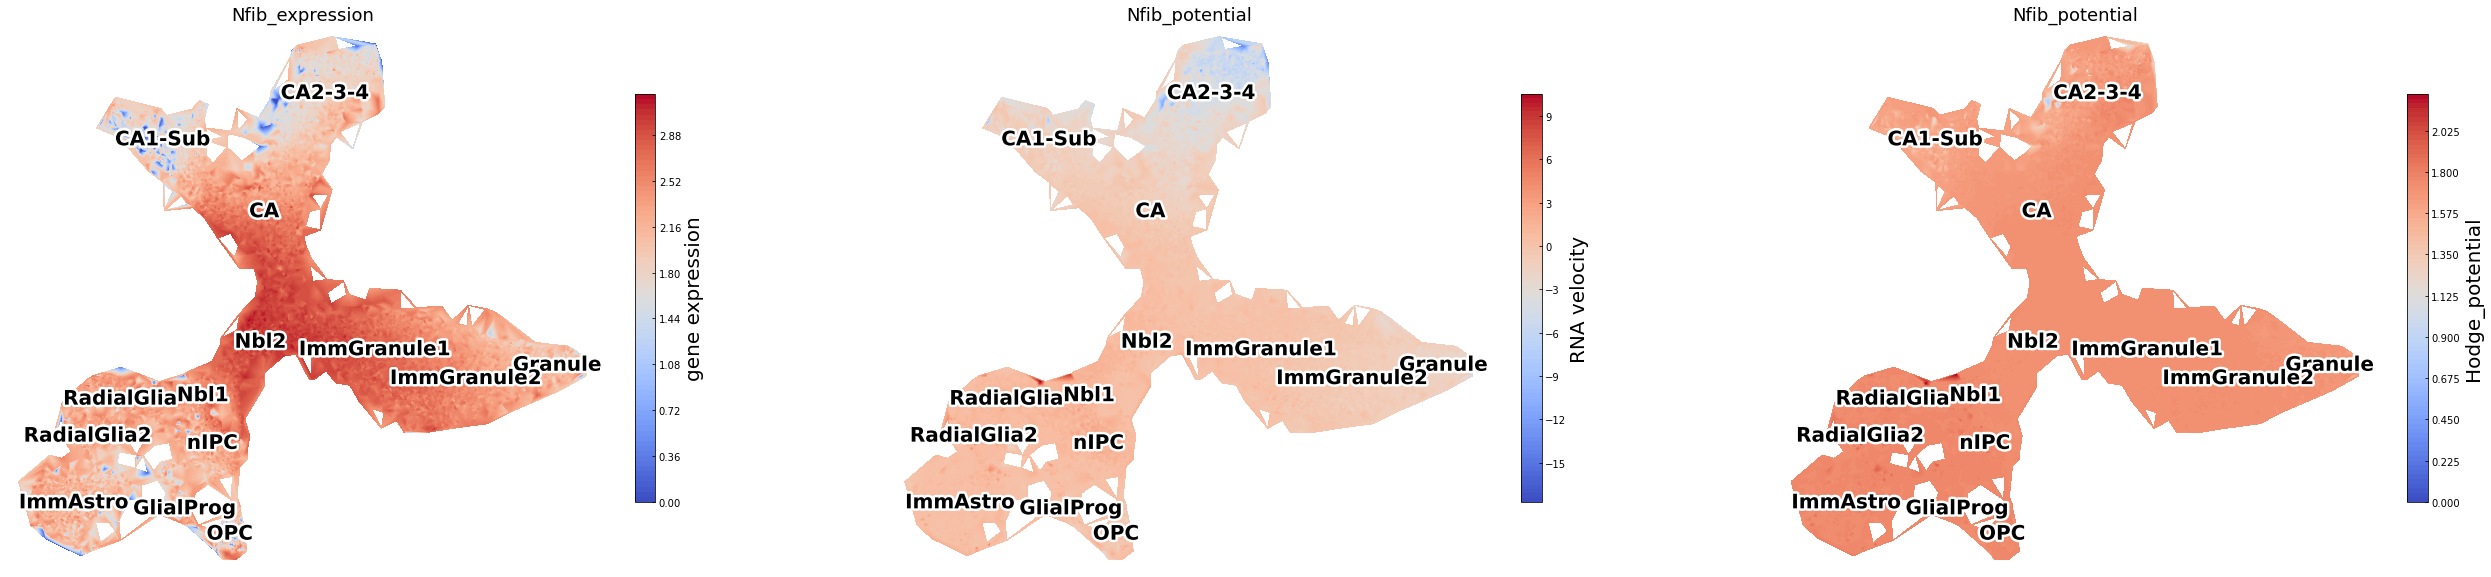

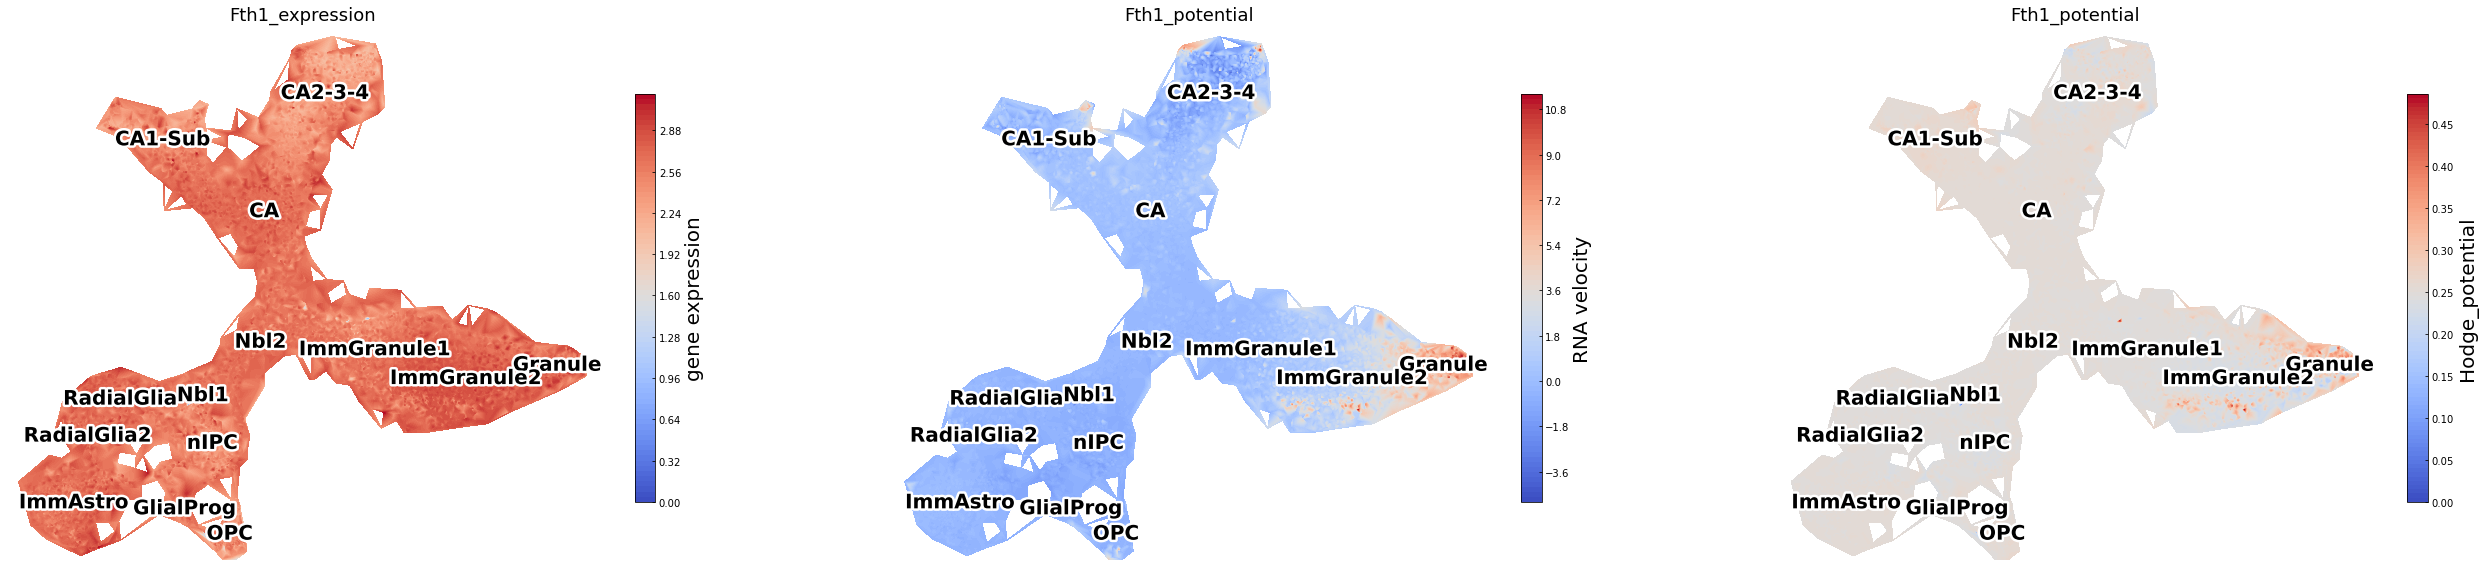

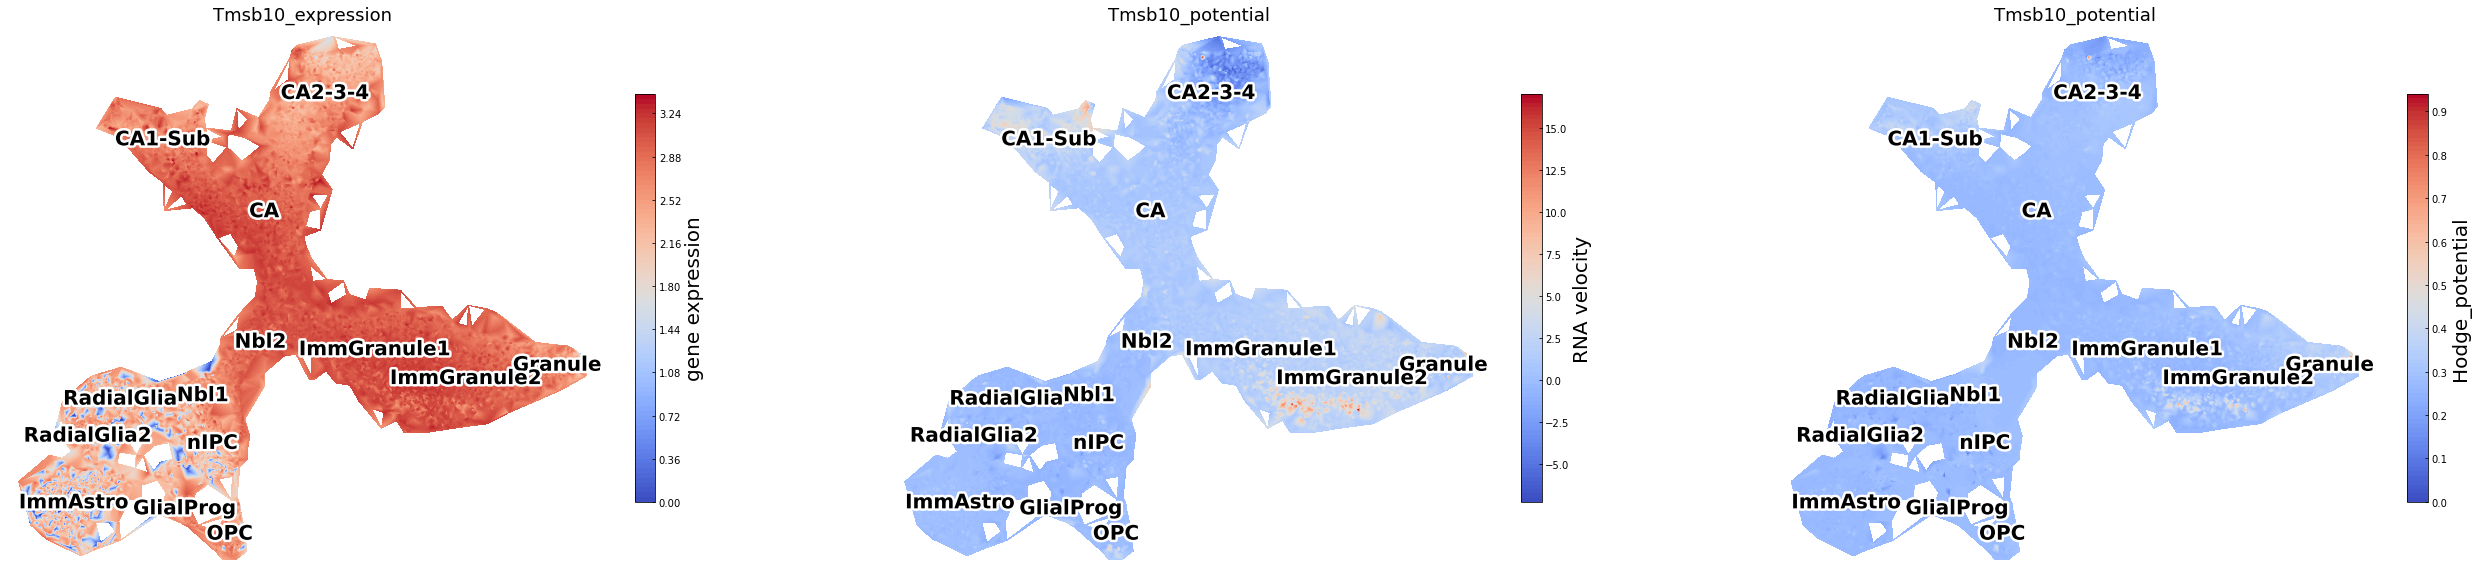

In [24]:
cellmap.view_surface_genes(adata,genes,exp_key='RECODE_log',cluster_key = 'clusters',cmap='coolwarm')